# Laboratory Work 2

In [12]:
import random 
from enum import Enum, auto
from graphviz import Digraph, Source

In [13]:
class FiniteAutomaton:
    def __init__(self, states, alphabet, transitions, initial_state, accept_states):
        self.states = states
        self.alphabet = alphabet
        self.transitions = transitions
        self.initial_state = initial_state
        self.accept_states = accept_states
        self.is_dfa = self.is_dfa()

    def is_dfa(self):
        for state, transitions in self.transitions.items():
            for symbol, next_states in transitions.items():
                # If there's more than one next state for a given symbol, it's not a DFA
                if len(next_states) > 1:
                    return False
        return True

    def accepts(self, input_string):
        curr_state = self.initial_state

        for symbol in input_string:
            # The symbol is not in the automaton's alphabet
            if symbol not in self.alphabet:
                return False 

            # Check if there's a transition defined for the current state and symbol
            if curr_state in self.transitions and symbol in self.transitions[curr_state]:
                curr_state = self.transitions[curr_state][symbol]
            else:
                return False 

        # Check if the current state after processing the input string is an accept state
        return curr_state in self.accept_states
    
    def to_reg_gr(self):
        non_terminals = self.states 
        terminals = self.alphabet
        start_symbol = self.initial_state
        rules = {nt: [] for nt in non_terminals}

        # Transform transitions into production rules
        for state, transitions in self.transitions.items():
            for symbol, next_states in transitions.items():
                for next_state in next_states:
                    rules[state].append(f"{symbol}{next_state}")
                    # If the next state is an accept state, add a production rule ending in the terminal
                    if next_state in self.accept_states and not self.transitions.get(next_state):
                        rules[state].append(symbol)

        return Grammar(non_terminals, terminals, rules, start_symbol)    

    def to_dfa(self):
        if self.is_dfa:
            return self
        
        init_s = self.initial_state
        dfa_transitions = {}
        dfa_accept_states = []
        queue = [frozenset([init_s])]
        visited = set()
        # Map the set of NFA states to DFA state names
        dfa_states_map = {frozenset([init_s]): init_s}

        while queue:
            current_states = queue.pop(0)
            if current_states in visited:
                continue
        
            visited.add(current_states)

            # The DFA state name
            dfa_state_name = self._state_set_to_name(current_states)
            dfa_transitions[dfa_state_name] = {}

            for symbol in self.alphabet:
                # Get the set of states for a given symbol
                next_states_set = frozenset(
                    [next_state for state in current_states for next_state in self.transitions.get(
                        state, {}).get(symbol, [])]
                )

                # If there are no next states, continue
                if not next_states_set:
                    continue

                next_state_name = self._state_set_to_name(next_states_set)

                # Store transitions as lists
                dfa_transitions[dfa_state_name][symbol] = [next_state_name]  

                if next_states_set not in dfa_states_map:
                    dfa_states_map[next_states_set] = next_state_name
                    queue.append(next_states_set)

                if next_states_set.intersection(self.accept_states):
                    dfa_accept_states.append(next_state_name)

        # Convert state names from sets to a list of state names
        # Necessary because the state names are used as keys in the transitions dictionary
        dfa_states = list(dfa_states_map.values())

        return FiniteAutomaton(
            states=dfa_states,
            alphabet=self.alphabet,
            transitions=dfa_transitions,
            initial_state=dfa_states_map[frozenset([self.initial_state])],
            accept_states=dfa_accept_states
        )

    def _state_set_to_name(self, states_set):
        # Return the existing state name if it's a single state
        if len(states_set) == 1:
            return next(iter(states_set))

        # Create a composite state name by joining state names with ,
        return ','.join(sorted(states_set))

    def create_diagram(self):
        dot = Digraph(comment='Finite Automaton')
        dot.attr(rankdir='LR')

        # Add states
        for state in self.states:
            dot.node(state, state, shape='doublecircle' if state in self.accept_states else 'circle')

        # Mark initial state
        dot.node('', '', shape='none')
        dot.edge('', self.initial_state)

        # Add transitions
        for state, transitions in self.transitions.items():
            for symbol, next_states in transitions.items():
                for next_state in next_states:
                    dot.edge(state, next_state, label=symbol)

        return dot

In [14]:
class GrammarType(Enum):
    UNRESTRICTED = 'Type 0: Unrestricted'
    CONTEXT_SENSITIVE = 'Type 1: Context-sensitive'
    CONTEXT_FREE = 'Type 2: Context-free'
    REGULAR_RIGHT_LINEAR = 'Type 3: Regular (right linear)'
    REGULAR_LEFT_LINEAR = 'Type 3: Regular (left linear)'

class Grammar:
    def __init__(self, non_terminals, terminals, rules, start='S'):
        self.non_terminals = non_terminals
        self.terminals = terminals
        self.rules = rules
        self.start = start
        self.type = self.get_type()

    def generate_string(self, symbol=None, len=0, max_len=15):
        # If no symbol is provided, use the start symbol
        if symbol is None:
            symbol = self.start

        # Check for exceeding the maximum length
        if len > max_len:
            return ''

        # Base case: symbol is terminal
        if symbol in self.terminals:
            return symbol

        if symbol in self.rules:
            # Random production
            production = random.choice(self.rules[symbol])
            result = ''
            for sym in production:
                result += self.generate_string(sym, len + 1, max_len)
            return result

        # The symbol doesn't match anything in the production
        return ''

    def get_type(self):
        is_context_free = True
        is_regular = True
        is_right_linear = False
        is_left_linear = False

        for lhs, rhs_list in self.rules.items():
            for rhs in rhs_list:
                # Check for context-sensitive violation
                if len(lhs) > len(rhs) or (len(lhs) > 1 and any(char in self.non_terminals for char in lhs)):
                    return GrammarType.UNRESTRICTED

                # Check for context-free violation 
                if len(lhs) != 1 or lhs not in self.non_terminals:
                    is_context_free = False
                    is_regular = False

                # Check for regular violation
                if is_regular:
                    if all(symbol in self.terminals for symbol in rhs):
                        continue
                    elif rhs[-1] in self.non_terminals and all(symbol in self.terminals for symbol in rhs[:-1]):
                        is_right_linear = True
                    elif rhs[0] in self.non_terminals and all(symbol in self.terminals for symbol in rhs[1:]):
                        is_left_linear = True
                    else:
                        is_regular = False

        if is_regular:
            if is_right_linear and not is_left_linear:
                return GrammarType.REGULAR_RIGHT_LINEAR
            elif is_left_linear and not is_right_linear:
                return GrammarType.REGULAR_LEFT_LINEAR
            else:
                raise ValueError('Grammar is not regular')

        if is_context_free:
            return GrammarType.CONTEXT_FREE

        return GrammarType.CONTEXT_SENSITIVE


    def convert_to_fa(self):
        if self.type not in [GrammarType.REGULAR_RIGHT_LINEAR, GrammarType.REGULAR_LEFT_LINEAR]:
            return None

        final_state = 'X'
        transitions = {}

        # Initialize transitions for all non-terminals
        for non_terminal in self.non_terminals:
            transitions[non_terminal] = {symbol: [] for symbol in self.terminals}

        # Initialize transitions for the X state
        transitions[final_state] = {
            symbol: [final_state] for symbol in self.terminals
        }

        # Populate transitions based on the grammar's production rules
        for non_terminal, productions in self.rules.items():
            for production in productions:
                # Production leading to final state
                if len(production) == 1:  
                    symbol = production
                    transitions[non_terminal][symbol] = [final_state]
                elif self.type == GrammarType.REGULAR_RIGHT_LINEAR:
                    symbol, new_state = production[0], production[1]
                    transitions[non_terminal][symbol].append(new_state)
                elif self.type == GrammarType.REGULAR_LEFT_LINEAR:
                    symbol, new_state = production[1], production[0]
                    transitions[non_terminal][symbol].append(new_state)

        # Remove empty transitions that have been replaced by X state transitions
        for state, trans in transitions.items():
            for symbol, next_states in trans.items():
                if not next_states:
                    trans[symbol] = [final_state]

        return FiniteAutomaton(
            states=self.non_terminals + [final_state],
            alphabet=self.terminals,
            transitions=transitions,
            initial_state=self.start,
            accept_states=[final_state]
        )

## Test - Variant 29

### Grammar type detection

In [15]:
# Type 0
non_terminals = ['S', 'A']
terminals = ['a', 'b']
rules = {
    'Sab': ['ba'],
    'A': ['S']
}
grammar = Grammar(non_terminals, terminals, rules)
print(grammar.type.value)


# Type 1
non_terminals = ['S', 'A']
terminals = ['a', 'b', 'c']
rules = {
    'S': ['AB'],
    'A': ['abc'],
    'B': ['b']
}
grammar = Grammar(non_terminals, terminals, rules)
print(grammar.type.value)

# Type 2
non_terminals = ['S', 'A', 'B']
terminals = ['a', 'b', 'c']
rules = {
    'S': ['ABa'],
    'A': ['a'],
    'B': ['b']
}
grammar = Grammar(non_terminals, terminals, rules)
print(grammar.type.value)


# Type 3 (right linear)
non_terminals = ['S', 'B', 'C', 'D']
terminals = ['a', 'b', 'c']
rules = {
    'S': ['aB', 'aB'],
    'B': ['bS', 'aC', 'c'],
    'C': ['bD'],
    'D': ['c', 'aC']
}
grammar = Grammar(non_terminals, terminals, rules)
print(grammar.type.value)

# Type 3 (left linear)
non_terminals = ['S', 'B', 'C', 'D']
terminals = ['a', 'b', 'c']
rules = {
    'S': ['Ba', 'Baa'],
    'B': ['Sb', 'Ca', 'c'],
    'C': ['Db'],
    'D': ['c', 'Ca']
}
grammar = Grammar(non_terminals, terminals, rules)
print(grammar.type.value)

Type 0: Unrestricted
Type 1: Context-sensitive
Type 2: Context-free
Type 3: Regular (right linear)
Type 3: Regular (left linear)


### FA to Regular Grammar conversion

$$
\begin{align*}
    Q &= \{q_0, q_1, q_2\}, \\
    \Sigma &= \{a, b, c\}, \\
    F &= \{q_2\}.
\end{align*}
$$

$$
\begin{align*}
    \delta(q_0, a) &= q_1, \\
    \delta(q_0, a) &= q_0, \\
    \delta(q_1, a) &= q_0, \\
    \delta(q_1, b) &= q_2, \\
    \delta(q_1, c) &= q_1, \\
    \delta(q_2, a) &= q_2, \\
\end{align*}
$$

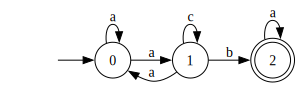

In [16]:
states = ['0', '1', '2']
alphabet = ['a', 'b', 'c']
transitions = {
    '0': {'a': ['1', '0']},
    '1': {'c': ['1'], 'b': ['2'], 'a': ['0']},
    '2': {'a': ['2']}
}
initial_state = '0'
accept_states = ['2']

fa = FiniteAutomaton(states, alphabet, transitions, initial_state, accept_states)
fa.create_diagram()

### FA to Regular Grammar conversion

In [17]:
rg = fa.to_reg_gr()

print(rg.type.value)
print(f'Start: {rg.start}')
print(f'Non-terminals: {rg.non_terminals}')
print(f'Terminals: {rg.terminals}')
print('Rules:')
for nt, rules in rg.rules.items():
    print(f'{nt} -> {" | ".join(rules)}')

Type 3: Regular (right linear)
Start: 0
Non-terminals: ['0', '1', '2']
Terminals: ['a', 'b', 'c']
Rules:
0 -> a1 | a0
1 -> c1 | b2 | a0
2 -> a2


### Regular Grammar to FA conversion back

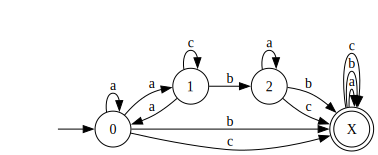

In [18]:
rg.convert_to_fa().create_diagram()

## NFA to DFA conversion

In [19]:
fa.is_dfa

False

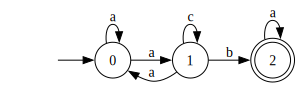

In [20]:
states = ['0', '1', '2']
alphabet = ['a', 'b', 'c']
transitions = {
    '0': {'a': ['1', '0']},
    '1': {'c': ['1'], 'b': ['2'], 'a': ['0']},
    '2': {'a': ['2']}
}
initial_state = '0'
accept_states = ['2']

nfa = FiniteAutomaton(states, alphabet, transitions, initial_state, accept_states)
nfa.create_diagram()

In [21]:
dfa = nfa.to_dfa()
print("Transitions:")
for state, transitions in dfa.transitions.items():
    print(f"Transitions from {state}:")
    for symbol, next_state in transitions.items():
        print(f"  {symbol} -> {next_state}")

Transitions:
Transitions from 0:
  a -> ['0,1']
Transitions from 0,1:
  a -> ['0,1']
  b -> ['2']
  c -> ['1']
Transitions from 2:
  a -> ['2']
Transitions from 1:
  a -> ['0']
  b -> ['2']
  c -> ['1']


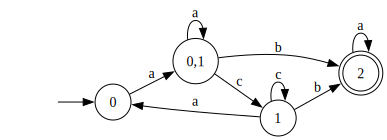

In [22]:
dfa.create_diagram()